# Descrição do Problema

O conjunto de dados em questão foi disponibilizado pelo Banco Santander em uma competição no site Kaggle. O problema consiste em identificar a partir das variáveis quais clientes estão insatisfeitos e são propensos a deixar o Banco. O conjunto de dados é completamente anonimizado.

Link para a competição no Kaggle: __[Santander Customer Satisfactions](https://www.kaggle.com/c/santander-customer-satisfaction)__

## 1. Primeiros Passos

Inicialmente, importaremos as bibliotecas necessárias e carregaremos os dados na memória.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 4)
plt.style.use('ggplot')

In [19]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [20]:
print('INFORMAÇÕES INICIAIS')
print(f'O conjunto de dados apresenta {len(train_df)} amostras e {len(train_df.columns)} colunas, divididas em:')
print(f'    - {len(train_df.select_dtypes(include= np.int64).columns)} colunas de dados inteiros')
print(f'    - {len(train_df.select_dtypes(include= np.float64).columns)} colunas de dados contínuos')
print(f'    - {len(train_df.select_dtypes(include= object).columns)} colunas de dados não-numéricos')
print(f'    - {len(train_df.select_dtypes(include= bool).columns)} colunas de dados booleanos')

INFORMAÇÕES INICIAIS
O conjunto de dados apresenta 76020 amostras e 371 colunas, divididas em:
    - 260 colunas de dados inteiros
    - 111 colunas de dados contínuos
    - 0 colunas de dados não-numéricos
    - 0 colunas de dados booleanos


Com 371 colunas, precisaremos focar grande parte de análise na escolha e engenharia de features, uma vez que esse número está muito alto paraa modelos de Machine Learning.

In [21]:
sum(train_df.isna().sum())

0

Não há dados ausentes.

In [51]:
train_df.duplicated().sum()

0

Não há dados duplicados

## 1.1 Análise da coluna alvo

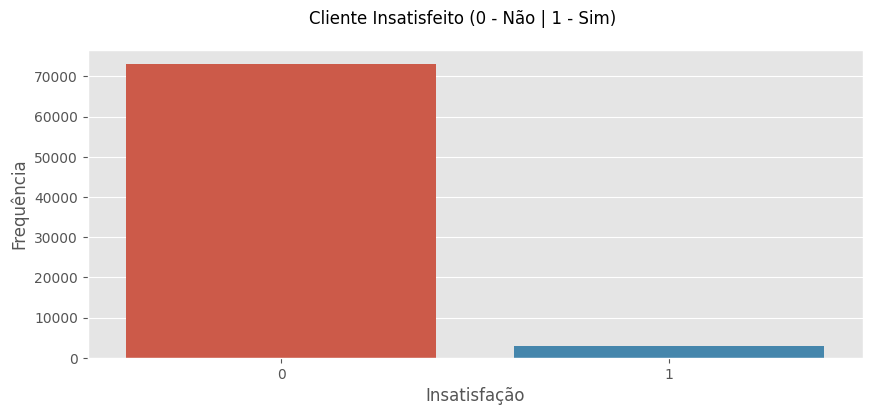

In [22]:
sns.countplot(data=train_df, x='TARGET')
plt.xlabel("Insatisfação")
plt.ylabel("Frequência")
plt.suptitle("Cliente Insatisfeito (0 - Não | 1 - Sim)")
plt.show()

Podemos ver que há um número muito maior de clientes satisfeitos na base de dados, ou seja, o conjunto é desbalanceado. Vamos analisar numericamente:

In [23]:
l = list(train_df.TARGET.value_counts())
p = [round(100*x/sum(l), 2) for x in l]
print("Conjunto de treino:")
print(f"Porcentagem de clientes satisfeitos: {p[0]}%")
print(f"Porcentagem de clientes insatisfeitos: {p[1]}%")

Conjunto de treino:
Porcentagem de clientes satisfeitos: 96.04%
Porcentagem de clientes insatisfeitos: 3.96%


Desse modo, devemos levar em consideração esse fato e aplicar técnicas de tratamento de dados desbalanceados.

## 1.2 Separando features da variável alvo:

In [24]:
X_train = train_df.drop(columns=["ID", "TARGET"])
y_train = train_df.TARGET

## 1.3 Modelo base com todas as features

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logit = LogisticRegression(solver='liblinear', max_iter=1_000)

cv = cross_val_score(
    logit, 
    X_train, 
    y_train, 
    cv=5,
    scoring='roc_auc',
    n_jobs=3
    )

cv

array([0.60857979, 0.60321757, 0.62151063, 0.58778402, 0.59990735])

## 1.4 Análise das variáveis independentes

### Análise a partir da variância das variáveis

In [26]:
print(f"Número de variáveis constantes: {sum(X_train.std() == 0)}")

Número de variáveis constantes: 34


Vemos que há 34 variáveis que apresentam variância nula, isto é, apresentam valor constante para todas as amostras. Podemos confirmar isso com a função VarianceThreshold do pacote sklearn.

In [27]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0)
selector.fit(X_train)

print(f"Número de features com variância diferente de zero: {sum(selector.get_support())}")
print(f"Número de features com variância iguais a zero: {len(X_train.columns) - sum(selector.get_support())}")

Número de features com variância diferente de zero: 335
Número de features com variância iguais a zero: 34


Podemos fazer uma nova avaliação com diferentes valores do parâmetro threshold que indica um limite de variância:

In [28]:
thresholds = [0.1, 0.5, 1, 5, 10, 50, 100]

for threshold in thresholds:
    print()
    selector = VarianceThreshold(threshold = threshold)
    selector.fit(X_train)

    print(f"Número de features com variância maior que {threshold}: {sum(selector.get_support())}")
    print(f"Número de features com variância menor que {threshold}: {len(X_train.columns) - sum(selector.get_support())}")


Número de features com variância maior que 0.1: 220
Número de features com variância menor que 0.1: 149

Número de features com variância maior que 0.5: 190
Número de features com variância menor que 0.5: 179

Número de features com variância maior que 1: 182
Número de features com variância menor que 1: 187

Número de features com variância maior que 5: 166
Número de features com variância menor que 5: 203

Número de features com variância maior que 10: 162
Número de features com variância menor que 10: 207

Número de features com variância maior que 50: 150
Número de features com variância menor que 50: 219

Número de features com variância maior que 100: 146
Número de features com variância menor que 100: 223


Obs: Colunas com variância 0 são colunas constantes e portanto não agregam nada ao treinamento, podendo ser retiradas do conjunto.

### Análise utilizando PCA

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


scaler = StandardScaler()
selector = VarianceThreshold(threshold=0)
pca = PCA(n_components=0.95)

logit = LogisticRegression(solver='liblinear', max_iter=1_000)

steps = [
    ("scaler", scaler),
    ("selector", selector),
    ("pca", pca),
    ("logit", logit)
]

pipe = Pipeline(steps = steps, verbose=True)

stratified_kfold = StratifiedKFold(n_splits=5)

cv = cross_val_score(
    pipe, 
    X_train, 
    y_train, 
    cv = stratified_kfold,
    scoring ='roc_auc',
    n_jobs = 3,
    verbose = 1
    )

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   51.8s finished


In [30]:
cv

array([0.79141187, 0.77676863, 0.80231642, 0.80724868, 0.78750414])

Podemos ver que utilizar PCA aumentou consideravelmente o score roc_auc.

# 2. Ajuste de hiperparâmetros da pipeline completa

Passos do modelo:

1. Aplicar um método de escala dos dados: StandardScaler, MinMaxScaler, etc.
2. Aplicar undersampling na classe majoritária
3. Aplicar oversampling na classe minoritária
4. Aplicar PCA para diminuir a dimensionalidade do sistema.
5. Aplicar o modelo.

In [55]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as imb_pipeline

from sklearn.exceptions import FitFailedWarning
import warnings

# Essas linhas servem apenas para ignorar avisos do scikit-learn sobre combinações de hiperparâmetros que não são possíveis.
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logreg = LogisticRegression()
over = BorderlineSMOTE()
under = RandomUnderSampler()

#pipe = imb_make_pipeline(preprocessing, under, over, rfe, logreg)
steps = [
    ("FeatureScaling", StandardScaler()),
    ("UnderSampling", RandomUnderSampler()),
    ("OverSampling", BorderlineSMOTE()),
    ("PrincipalComponent", PCA()),
    ("LogisticRegression", LogisticRegression(verbose=1))
]

classifier = imb_pipeline(steps)


# define search space
space = dict()
space["UnderSampling__sampling_strategy"] = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
space["OverSampling__sampling_strategy"] = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
space["PrincipalComponent__n_components"] = np.linspace(0.5, 1.0, 20)
space['LogisticRegression__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['LogisticRegression__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['LogisticRegression__C'] = loguniform(1e-5, 100)


# define search
search = RandomizedSearchCV(
    classifier, 
    space, 
    n_iter=250, 
    scoring='roc_auc', 
    n_jobs=3, 
    cv=4, 
    random_state=1)

# execute search
result = search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [56]:
print(result.best_params_)
print(result.best_score_)
print(result.best_estimator_)

{'LogisticRegression__C': 1.7864713455086948e-05, 'LogisticRegression__penalty': 'none', 'LogisticRegression__solver': 'newton-cg', 'OverSampling__sampling_strategy': 0.8, 'PrincipalComponent__n_components': 0.9473684210526315, 'UnderSampling__sampling_strategy': 0.7}
0.7930982508995899
Pipeline(steps=[('FeatureScaling', StandardScaler()),
                ('UnderSampling', RandomUnderSampler(sampling_strategy=0.7)),
                ('OverSampling', BorderlineSMOTE(sampling_strategy=0.8)),
                ('PrincipalComponent', PCA(n_components=0.9473684210526315)),
                ('LogisticRegression',
                 LogisticRegression(C=1.7864713455086948e-05, penalty='none',
                                    solver='newton-cg', verbose=1))])


# 3. Conjunto de teste

In [57]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Columns: 370 entries, ID to var38
dtypes: float64(110), int64(260)
memory usage: 214.0 MB


In [59]:
X_test = test_df.drop(columns=["ID"])

In [66]:
predictions = result.best_estimator_.fit(X_train, y_train).predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [67]:
test_df['TARGET'] = predictions

In [68]:
test_df[["ID", "TARGET"]].to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Latest Submission"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/686k [00:00<?, ?B/s]
  1%|          | 8.00k/686k [00:00<00:24, 28.4kB/s]
 15%|█▌        | 104k/686k [00:00<00:01, 334kB/s]  
 56%|█████▌    | 384k/686k [00:00<00:00, 1.10MB/s]
100%|██████████| 686k/686k [00:02<00:00, 268kB/s] 


In [75]:
!kaggle competitions submissions -q -c santander-customer-satisfaction

fileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
submission.csv  2023-04-27 17:46:49  Message      complete  0.73531      0.72378       
submission.csv  2023-04-27 17:34:27  Message      complete  0.50138      0.50088       
submission.csv  2023-04-27 16:32:06  Teste        complete  0.50138      0.50088       


O conjunto de teste não apresenta a variável alvo. Para testar o score é preciso submeter as previsões e observar o score atribuído pelo Kaggle. São atribuídos dois scores: público (com 20% do conjunto de teste) e privado ( com 80% do conjunto de teste).

A última submissão obteve um score de 0.735 e um score privado de 0.723.